In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter("ignore")

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device {device}")

Using device cuda


Example on how functions from `extraction_refactored.py` can be used, especially one which calculates perplexity

In [3]:
from extraction_refactored import calculate_perplexity, parse_model_name

model_name = "bigcode/starcoderbase-1b"
model, tokenizer = parse_model_name(model_name)
model.to(device)
text1 = "import pandas as pd\nimport numpy as np"
text2 = "#include <iostream>"
perplexity_score1 = calculate_perplexity(text1, model, tokenizer).item()
perplexity_score2 = calculate_perplexity(text2, model, tokenizer).item()
print(perplexity_score1)
print(perplexity_score2)

Using device cuda
4.501964092254639
7.048807621002197


## Now exploring results we got from scripts
We download results from file with samples, then iterate through dataset chunks and check if this code is some substring.

In [4]:
from utilities import read_results, search_in_train

xl_top_scores, s_top_scores, texts = read_results("results_full")
quarter = len(s_top_scores) // 3
uniques = pd.DataFrame(
    {
        "xl_score": xl_top_scores[quarter:],
        "other_score": s_top_scores,
        "text": texts[quarter:],
    }
).drop_duplicates(["text"])
total = search_in_train("t5_dataset", uniques["text"], "code")
train_texts = [
    text
    for text in uniques
    if total[total["code"].apply(lambda x: text in str(x))].shape[0] > 0
]

Drop duplicates of same paths and some code to see the overall picture.

In [ ]:
total_no_dupl = total.drop_duplicates(["path"]).drop_duplicates(["code"])
total_no_dupl.head(10)

,code,repo_name,path,language,license,size
29070,"#include ""qrcodedialog.h""\n#include ""ui_qrcode...",elco-coin/elcoin-source,src/qt/qrcodedialog.cpp,C++,mit,4309.0
225696,"/*\n * Copyright 2014-2019 Amazon.com, Inc. or...",jentfoo/aws-sdk-java,aws-java-sdk-glue/src/main/java/com/amazonaws/...,Java,apache-2.0,7408.0
272585,"/*\n * Copyright 2014-2019 Amazon.com, Inc. or...",jentfoo/aws-sdk-java,aws-java-sdk-glue/src/main/java/com/amazonaws/...,Java,apache-2.0,3381.0
580673,// \n// Copyright (c) Microsoft and contributo...,namratab/azure-sdk-for-net,src/ResourceManagement/Network/NetworkManageme...,C#,apache-2.0,3544.0
1103503,"/*\n * Copyright 2014-2019 Amazon.com, Inc. or...",jentfoo/aws-sdk-java,aws-java-sdk-glue/src/main/java/com/amazonaws/...,Java,apache-2.0,4023.0
1363794,"/*\n * Copyright 2014-2019 Amazon.com, Inc. or...",jentfoo/aws-sdk-java,aws-java-sdk-glue/src/main/java/com/amazonaws/...,Java,apache-2.0,3287.0
1659519,// \n// Copyright (c) Microsoft and contributo...,nemanja88/azure-sdk-for-net,src/ResourceManagement/Network/NetworkManageme...,C#,apache-2.0,4173.0


Check for appearances of memorized texts in train set. Also consider text which is most probably was fully memorized and in train set.

In [ ]:
train_counts = np.array(
    [
        total[total["code"].apply(lambda x: text in str(x))].shape[0]
        for text in train_texts
    ]
)
print(train_counts)
most_probably_train_text = train_texts[np.argmin(train_counts)]
print(most_probably_train_text)

[31]
text


Downloading logged scores for different methods

In [ ]:
scores_S = np.load("scores_S", allow_pickle=True)
scores_XL = np.load("scores_XL", allow_pickle=True)
scores_zlib = np.load("scores_zlib", allow_pickle=True)
scores_Lower = np.load("scores_Lower", allow_pickle=True)

In [ ]:
scores_S.shape, scores_XL.shape, scores_Lower.shape, scores_zlib.shape

((7962,), (7962,), (7962,), (7962,))

Plotting different scores for all points (gray), memorized_points (blue), chosen points (red)

Scores between model and smaller model


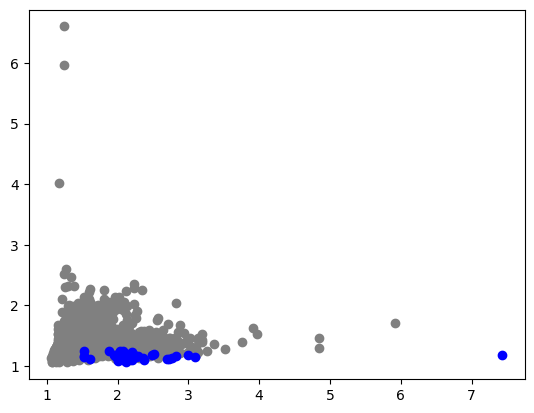

In [ ]:
print("Scores between model and smaller model")
plt.scatter(scores_S, scores_XL, color="gray")
plt.scatter(
    s_top_scores[:quarter],
    xl_top_scores[quarter : 2 * quarter],
    color="blue",
)
plt.scatter(
    uniques[
        uniques["text"].apply(
            lambda x: x in total.loc[quarter : 2 * quarter, :]["code"]
        )
    ]["other_score"],
    uniques[
        uniques["text"].apply(
            lambda x: x in total.loc[quarter : 2 * quarter, :]["code"]
        )
    ]["xl_score"],
    color="red",
)

In [ ]:
print("Scores between model and Lower-case inputs for same model")
plt.scatter(scores_Lower, scores_XL, color="gray")
plt.scatter(
    s_top_scores[quarter : 2 * quarter],
    xl_top_scores[2 * quarter : 3 * quarter],
    color="blue",
)
plt.scatter(
    uniques[
        uniques["text"].apply(
            lambda x: x in total.loc[2 * quarter : 3 * quarter, :]["code"]
        )
    ]["other_score"],
    uniques[
        uniques["text"].apply(
            lambda x: x in total.loc[2 * quarter : 3 * quarter, :]["code"]
        )
    ]["xl_score"],
    color="red",
)

In [ ]:
print("Scores between model and zlib-compression")
plt.scatter(scores_zlib, scores_XL, color="gray")
plt.scatter(s_top_scores[2 * quarter : 3 * quarter], xl_top_scores[3 * quarter :], color="blue")
plt.scatter(
    uniques[uniques["text"].apply(lambda x: x in total.loc[3 * quarter :, :]["code"])][
        "other_score"
    ],
    uniques[uniques["text"].apply(lambda x: x in total.loc[3 * quarter :, :]["code"])][
        "xl_score"
    ],
    color="red",
)